X_mass shape: (15000, 256, 256)
X_vel shape: (15000, 256, 256)
Y_gas shape: (15000, 256, 256)
Y_temp shape: (15000, 256, 256)
Dark Matter Mass min-max: 2655544064.0 - 2499223484366848.0
Dark Matter Velocity min-max: 4.384753227233887 - 1797.47607421875
Gas Density min-max: 694237120.0 - 250120155168768.0
Temperature min-max: 1502.0494384765625 - 83233224.0


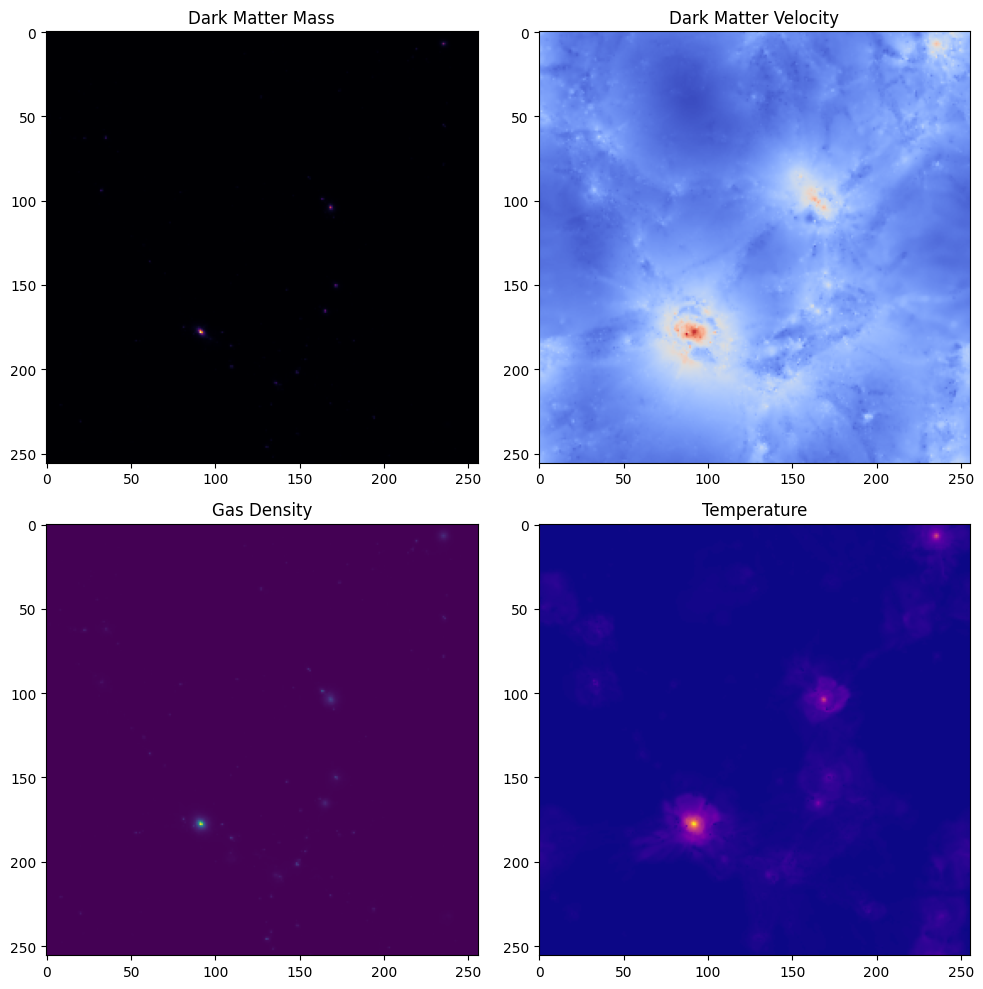

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data (ensure paths are correct)
X_mass = np.load(r"/home/amanbh/projects/tf217/DISS/Maps_Mcdm_IllustrisTNG_LH_z=0.00.npy")
X_vel = np.load(r"/home/amanbh/projects/tf217/DISS/Maps_Vcdm_IllustrisTNG_LH_z=0.00.npy")
Y_gas = np.load(r"/home/amanbh/projects/tf217/DISS/Maps_Mgas_IllustrisTNG_LH_z=0.00.npy")
Y_temp = np.load(r"/home/amanbh/projects/tf217/DISS/Maps_T_IllustrisTNG_LH_z=0.00.npy")

# Check shapes
print(f"X_mass shape: {X_mass.shape}")
print(f"X_vel shape: {X_vel.shape}")
print(f"Y_gas shape: {Y_gas.shape}")
print(f"Y_temp shape: {Y_temp.shape}")

# Check min-max values (ensuring normalization is needed)
print(f"Dark Matter Mass min-max: {X_mass.min()} - {X_mass.max()}")
print(f"Dark Matter Velocity min-max: {X_vel.min()} - {X_vel.max()}")
print(f"Gas Density min-max: {Y_gas.min()} - {Y_gas.max()}")
print(f"Temperature min-max: {Y_temp.min()} - {Y_temp.max()}")

# Plot a few sample images
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(X_mass[0], cmap="inferno")
axs[0, 0].set_title("Dark Matter Mass")

axs[0, 1].imshow(X_vel[0], cmap="coolwarm")
axs[0, 1].set_title("Dark Matter Velocity")

axs[1, 0].imshow(Y_gas[0], cmap="viridis")
axs[1, 0].set_title("Gas Density")

axs[1, 1].imshow(Y_temp[0], cmap="plasma")
axs[1, 1].set_title("Temperature")

plt.tight_layout()
plt.show()




In [2]:
import numpy as np
import gc  # Garbage collector

def safe_log_normalize(data, epsilon=1e-6):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized = np.log1p(data - min_val + epsilon) / np.log1p(max_val - min_val + epsilon)
    return normalized

# Use a smaller batch size
batch_size = 10  # Reduced from 50

# Make sure your arrays are initialized before conversion
# X_mass, X_vel, Y_gas, Y_temp should be defined before this code

# Process one array at a time
print("Processing X_mass...")
X_mass = X_mass.astype(np.float32)
X_mass_norm = np.zeros_like(X_mass, dtype=np.float32)
for i in range(0, len(X_mass), batch_size):
    X_mass_norm[i:i+batch_size] = safe_log_normalize(X_mass[i:i+batch_size])
del X_mass  # Free memory
gc.collect()  # Force garbage collection

print("Processing X_vel...")
X_vel = X_vel.astype(np.float32)
X_vel_norm = np.zeros_like(X_vel, dtype=np.float32)
for i in range(0, len(X_vel), batch_size):
    X_vel_norm[i:i+batch_size] = safe_log_normalize(X_vel[i:i+batch_size])
del X_vel
gc.collect()

print("Processing Y_gas...")
Y_gas = Y_gas.astype(np.float32)
Y_gas_norm = np.zeros_like(Y_gas, dtype=np.float32)
for i in range(0, len(Y_gas), batch_size):
    Y_gas_norm[i:i+batch_size] = safe_log_normalize(Y_gas[i:i+batch_size])
del Y_gas
gc.collect()

print("Processing Y_temp...")
Y_temp = Y_temp.astype(np.float32)
Y_temp_norm = np.zeros_like(Y_temp, dtype=np.float32)
for i in range(0, len(Y_temp), batch_size):
    Y_temp_norm[i:i+batch_size] = safe_log_normalize(Y_temp[i:i+batch_size])
del Y_temp
gc.collect()

print("Normalization complete!")

Processing X_mass...
Processing X_vel...
Processing Y_gas...
Processing Y_temp...
Normalization complete!


In [3]:
# Stack inputs and outputs into channels
X = np.stack([X_mass_norm, X_vel_norm], axis=-1)  # Shape: (15000, 256, 256, 2)
Y = np.stack([Y_gas_norm, Y_temp_norm], axis=-1)  # Shape: (15000, 256, 256, 2)

print(f"Final Input shape: {X.shape}, Output shape: {Y.shape}")

: 

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

# --- Define U-Net Model ---
def unet_model(input_shape):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    # Decoder
    up1 = UpSampling2D(size=(2, 2))(conv4)
    up1 = Conv2D(256, (3, 3), activation='relu', padding='same')(up1)
    merge1 = Concatenate()([up1, conv3])

    up2 = UpSampling2D(size=(2, 2))(merge1)
    up2 = Conv2D(128, (3, 3), activation='relu', padding='same')(up2)
    merge2 = Concatenate()([up2, conv2])

    up3 = UpSampling2D(size=(2, 2))(merge2)
    up3 = Conv2D(64, (3, 3), activation='relu', padding='same')(up3)
    merge3 = Concatenate()([up3, conv1])

    outputs = Conv2D(2, (1, 1), activation='sigmoid')(merge3)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Initialize and compile the model
model = unet_model(X.shape[1:])
model.summary()


2025-03-10 18:49:26.887897: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-10 18:49:27.030445: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741632567.084168  371120 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741632567.102974  371120 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-10 18:49:27.264321: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

NameError: name 'X' is not defined

In [4]:
import tensorflow as tf

print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPUs available:", tf.config.list_physical_devices('GPU'))


ModuleNotFoundError: No module named 'tensorflow'